# **Quality of Experience Estimation**
#### **ALAA NAMLA (11109662), YASEEN ABDULMAHDI (11135947)**

--------------------------------

## Import Required Libraries
-----------------------------------

In [ ]:
# ── Standard library ───────────────────────────────────────────
import os
import time
import datetime
from pathlib import Path
from collections import defaultdict
from contextlib import suppress
import warnings
warnings.filterwarnings("ignore")

# ── Scientific stack ───────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# ── Scikit-learn core utilities ────────────────────────────────
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, average_precision_score,
    precision_recall_curve, confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ── XGBoost ────────────────────────────────────────────────────
from xgboost import XGBClassifier

# ── Persistence and explainability ─────────────────────────────
import joblib
with suppress(ImportError):
    import shap
    from sklearn.inspection import permutation_importance

# ── Plotting defaults ──────────────────────────────────────────
plt.rcParams["figure.figsize"] = (8, 4)
sns.set_style("whitegrid")
RNG = 42


##Data Loading & Initial Cleaning
------------------------------------------------
Read the raw CSV/PKL files, drop index columns, check shape and missing values.


In [ ]:
# Configuration

DATA_DIR = Path("/content/")
TRAIN_PATH = DATA_DIR / "BasicDataset_Training_MRN.csv"
TEST_PATH = DATA_DIR / "BasicDataset_Test_MRN.csv"

#Load datasets
assert TRAIN_PATH.exists(), f"Training file not found: {TRAIN_PATH}"
assert TEST_PATH.exists(), f"Test file not found: {TEST_PATH}"
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

#Drop obvious non‑informative columns (e.g., automatic index)
for df in (train_df, test_df):
    cols_to_drop = [c for c in df.columns if c.lower().startswith("unnamed")]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"Dropped {cols_to_drop} from {'train' if df is train_df else 'test'} set.")

# Quick overview
print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print("\nPreview of training data:")
display(train_df.head())
print("\nData types & non‑null counts (train set):")
train_df.info()

# Missing‑value inspection
missing = train_df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if not missing.empty:
    plt.figure(figsize=(10, 4))
    missing.plot(kind="bar")
    plt.title("Missing value count per column (train set)")
    plt.ylabel("# NaNs")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected in the training set.")

# Split features & target
TARGET_COL = "User_Satisfaction"
if TARGET_COL not in train_df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in training data. Please update TARGET_COL.")

y = train_df[TARGET_COL]
X = train_df.drop(columns=[TARGET_COL])
print(f"\nPositive‑class proportion: {y.mean():.3f}")

# 1.7 Persist cleaned versions for next stages
train_df.to_pickle("train_clean.pkl")
test_df.to_pickle("test_clean.pkl")
print("\nCleaned data saved as 'train_clean.pkl' and 'test_clean.pkl'.")

Dropped ['Unnamed: 0.1', 'Unnamed: 0'] from train set.
Dropped ['Unnamed: 0.1', 'Unnamed: 0'] from test set.
Train shape: (18970, 13)
Test  shape: (4743, 13)

Preview of training data:


,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,User_Satisfaction,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE
0,100.727,110854.0,0.000,0.0,-6.0,27.8,1.0,53917,5636,2043,213227,3996,2883
1,9.324,93.0,0.000,0.0,-3.0,-19.8,0.0,85021,1761,1223,87700,4287,1251
2,2715.406,2271118.0,580.907,63891.0,-3.0,-19.8,0.0,123462,4664,2715,203846,5776,8748
3,74.097,39065.0,0.000,0.0,-4.0,-19.8,0.0,85675,4903,1322,7924,1799,9491
4,168.955,41933.0,0.000,0.0,-3.0,-19.9,1.0,104902,2068,669,137121,3846,937



Data types & non‑null counts (train set):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18970 entries, 0 to 18969
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Cumulative_YoutubeSess_LTE_DL_Time     18970 non-null  float64
 1   Cumulative_YoutubeSess_LTE_DL_Volume   18970 non-null  float64
 2   Cumulative_YoutubeSess_UMTS_DL_Time    18970 non-null  float64
 3   Cumulative_YoutubeSess_UMTS_DL_Volume  18970 non-null  float64
 4   Max_RSRQ                               18970 non-null  float64
 5   Max_SNR                                18970 non-null  float64
 6   User_Satisfaction                      18970 non-null  float64
 7   Cumulative_Full_Service_Time_UMTS      18970 non-null  int64  
 8   Cumulative_Lim_Service_Time_UMTS       18970 non-null  int64  
 9   Cumulative_No_Service_Time_UMTS        18970 non-null  int64  
 10  Cumulative_Full_Service_Tim

---------------------------------------------------
### Feature Dictionary  
  
Below is a consolidated reference for every variable used in the notebook.  
The first table lists the **12 original network counters** shipped in the raw dataset,  
and the second table documents the **engineered ratios and shares** we create in Step 3.

#### Base counters  

| Variable | Meaning |
| --- | --- |
| **Cumulative_YoutubeSess_LTE_DL_Time** | Total time (last 30 days) spent in **LTE** down-link YouTube sessions. |
| **Cumulative_YoutubeSess_LTE_DL_Volume** | Total bytes downloaded in LTE YouTube sessions over the last 30 days. |
| **Cumulative_YoutubeSess_UMTS_DL_Time** | Total time spent in **UMTS/3 G** down-link YouTube sessions (30 days). |
| **Cumulative_YoutubeSess_UMTS_DL_Volume** | Total bytes downloaded in UMTS YouTube sessions (30 days). |
| **Max_RSRQ** | Maximum Reference-Signal-Received Quality reported by the handset in the last 30 days. |
| **Max_SNR** | Maximum Signal-to-Noise Ratio reported in the last 30 days. |
| **Cumulative_Full_Service_Time_UMTS** | Time in UMTS **full-service** coverage over 30 days. |
| **Cumulative_Lim_Service_Time_UMTS** | Time in UMTS **limited-service** (degraded) coverage over 30 days. |
| **Cumulative_No_Service_Time_UMTS** | Time in UMTS **no-service** over 30 days. |
| **Cumulative_Full_Service_Time_LTE** | Time in LTE **full-service** coverage over 30 days. |
| **Cumulative_Lim_Service_Time_LTE** | Time in LTE **limited-service** coverage over 30 days. |
| **Cumulative_No_Service_Time_LTE** | Time in LTE **no-service** over 30 days. |

#### Engineered features  

| Variable | Formula | Interpretation |
| --- | --- | --- |
| **LTE_to_UMTS_DL_Time** | `LTE_DL_Time / (UMTS_DL_Time + ε)` | Ratio of YouTube watch-time on LTE vs UMTS; >1 ⇒ user mainly on LTE. |
| **LTE_to_UMTS_DL_Volume** | `LTE_DL_Volume / (UMTS_DL_Volume + ε)` | Same ratio but for downloaded bytes. |
| **UMTS_NoSvc_Share** | `UMTS_No_Service / Total_UMTS` | Fraction of UMTS time with **no service**. |
| **UMTS_LimSvc_Share** | `UMTS_Limited_Service / Total_UMTS` | Fraction of UMTS time with **limited service**. |
| **UMTS_FullSvc_Share** | `UMTS_Full_Service / Total_UMTS` | Fraction of UMTS time with **full service**. |
| **LTE_NoSvc_Share** | `LTE_No_Service / Total_LTE` | Fraction of LTE time with **no service**. |
| **LTE_LimSvc_Share** | `LTE_Limited_Service / Total_LTE` | Fraction of LTE time with **limited service**. |
| **LTE_FullSvc_Share** | `LTE_Full_Service / Total_LTE` | Fraction of LTE time with **full service**. |

<sub>ε = 1 × 10⁻⁶ to avoid divide-by-zero.</sub>



## Exploratory Data Analysis (EDA)
----------------------------------------------------
Plot class distribution, correlation heat-map and per-feature KDEs to understand data spread and potential issues.

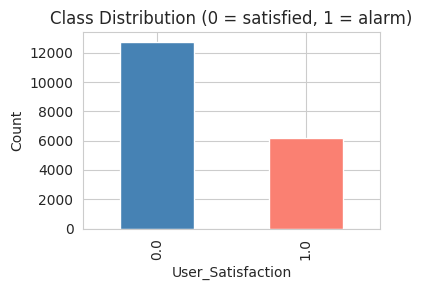


Class counts:
 User_Satisfaction
0.0    12758
1.0     6212
Name: count, dtype: int64
Class balance (percent unsatisfied): 32.74644175013179


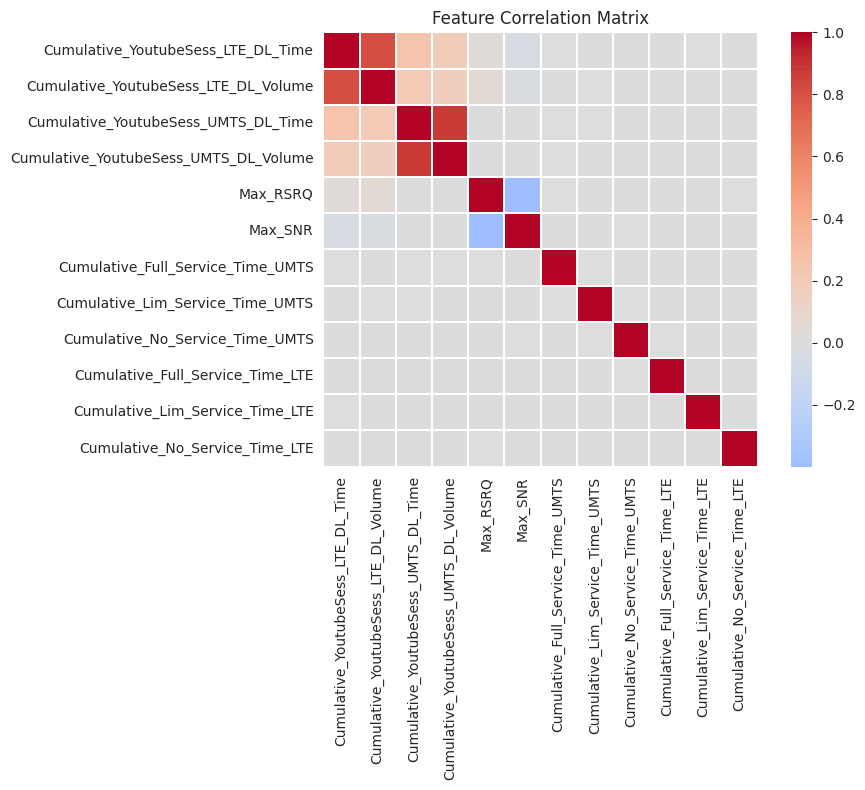


Plotting KDE for: ['Cumulative_YoutubeSess_LTE_DL_Volume', 'Cumulative_YoutubeSess_UMTS_DL_Volume', 'Cumulative_Full_Service_Time_LTE', 'Cumulative_Full_Service_Time_UMTS', 'Cumulative_No_Service_Time_LTE', 'Cumulative_Lim_Service_Time_UMTS']


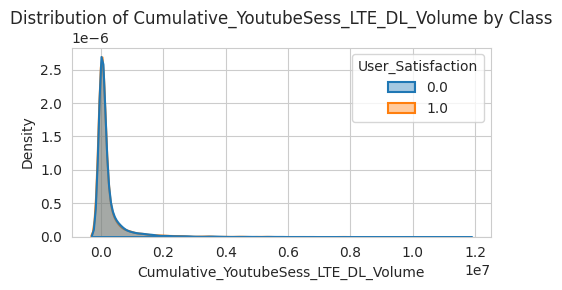

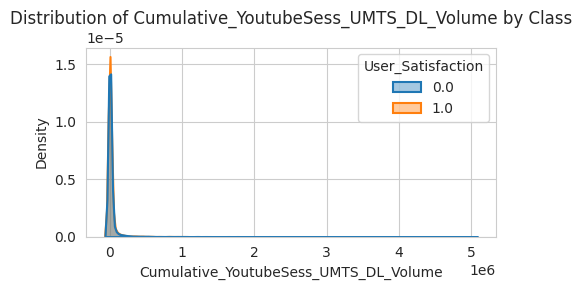

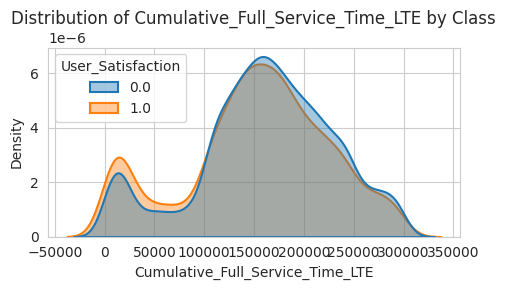

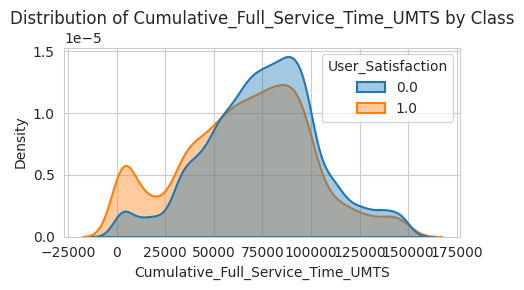

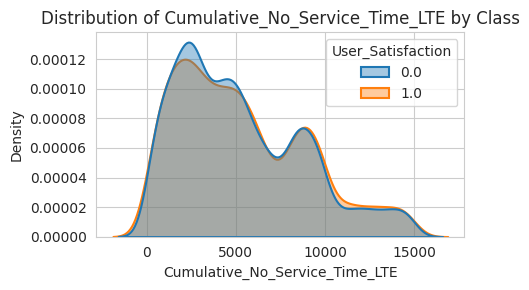

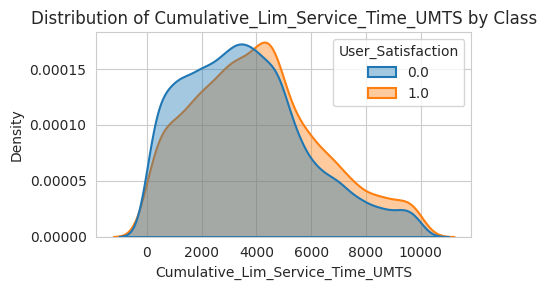

In [ ]:
sns.set_style("whitegrid")

# Load cleaned training data
df = pd.read_pickle("train_clean.pkl")

# Class distribution
plt.figure(figsize=(4,3))
class_counts = df['User_Satisfaction'].value_counts().sort_index()
class_counts.plot(kind='bar', color=["steelblue", "salmon"])
plt.title('Class Distribution (0 = satisfied, 1 = alarm)')
plt.xlabel('User_Satisfaction')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\nClass counts:\n", class_counts)
print("Class balance (percent unsatisfied):", class_counts.get(1,0) / len(df) * 100)

# Correlation heatmap
corr = df.drop(columns=['User_Satisfaction']).corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(corr, cmap='coolwarm', center=0, square=True, linewidths=0.1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# KDE distributions for selected numeric columns
numeric_cols = [c for c in df.columns if c != 'User_Satisfaction']
# Choose up to 6 representative features (simple heuristic: highest variance)
sel_cols = df[numeric_cols].var().sort_values(ascending=False).head(6).index.tolist()
print("\nPlotting KDE for:", sel_cols)

for col in sel_cols:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df, x=col, hue='User_Satisfaction', common_norm=False, fill=True, alpha=0.4, linewidth=1.5)
    plt.title(f'Distribution of {col} by Class')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

EDA shows a mild class imbalance (≈33 % alarms), strong collinearity among YouTube traffic counters, and visibly higher ‘limited/no-service’ times—especially on UMTS—among unsatisfied users, suggesting radio-coverage issues are a primary driver of poor QoE.

## Feature Engineering & Scaling
---------------------------------------------
Add traffic ratios and service-time shares, apply log1p to skewed counters, z-scale all features.

In [ ]:
train = pd.read_pickle("train_clean.pkl")
test  = pd.read_pickle("test_clean.pkl")

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Avoid division by zero with a small epsilon
    eps = 1e-6

    # --- Ratios LTE vs UMTS (DL time & volume) ---
    df["LTE_to_UMTS_DL_Time"]    = df["Cumulative_YoutubeSess_LTE_DL_Time"]   / (df["Cumulative_YoutubeSess_UMTS_DL_Time"]  + eps)
    df["LTE_to_UMTS_DL_Volume"]  = df["Cumulative_YoutubeSess_LTE_DL_Volume"] / (df["Cumulative_YoutubeSess_UMTS_DL_Volume"]+ eps)

    # --- Service-time shares (per RAT) ---
    for rat in ["LTE", "UMTS"]:
        full = df[f"Cumulative_Full_Service_Time_{rat}"]
        lim  = df[f"Cumulative_Lim_Service_Time_{rat}"]
        no   = df[f"Cumulative_No_Service_Time_{rat}"]
        total = full + lim + no + eps

        df[f"{rat}_NoSvc_Share"]  = no   / total
        df[f"{rat}_LimSvc_Share"] = lim  / total
        df[f"{rat}_FullSvc_Share"]= full / total

    # --- Log-scale skewed counters (log1p) ---
    skew_cols = [c for c in df.columns if "Cumulative_" in c or c.endswith("_Share") or "LTE_to" in c]
    df[skew_cols] = np.log1p(df[skew_cols])

    # Replace inf/-inf and fill potential NaN generated by log/ratio
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    return df

# Apply to train/test (do NOT touch the label column)
y_train = train["User_Satisfaction"]
X_train = add_engineered_features(train.drop(columns=["User_Satisfaction"]))
X_test  = add_engineered_features(test.drop(columns=["User_Satisfaction"]))

# ---------- Standard scaling ----------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

# ---------- Save artefacts --------------------------------------------------
X_train_scaled["User_Satisfaction"] = y_train
joblib.dump(scaler, "feature_scaler.joblib")

# keep two versions of the engineered test set
if "User_Satisfaction" in test.columns:
    # labelled version for evaluation
    X_test_scaled["User_Satisfaction"] = test["User_Satisfaction"]
    X_test_scaled.to_pickle("test_fe_with_labels.pkl")
    test_fe_filename = "test_fe_with_labels.pkl"
else:
    # unlabelled version for production scoring
    X_test_scaled.to_pickle("test_fe.pkl")
    test_fe_filename = "test_fe.pkl"

X_train_scaled.to_pickle("train_fe.pkl")
print("Saved: train_fe.pkl  |  test_fe_with_labels.pkl / test_fe.pkl")


raw_test   = pd.read_pickle("test_clean.pkl")
proc_test  = pd.read_pickle("test_fe_with_labels.pkl")
train_fe   = pd.read_pickle("train_fe.pkl")

print("Raw Test Set shape        :", raw_test.shape)
print("Processed Test Set shape  :", proc_test.shape)
print("Processed Train Set shape :", train_fe.shape)

Saved: train_fe.pkl  |  test_fe_with_labels.pkl / test_fe.pkl
Raw Test Set shape        : (4743, 13)
Processed Test Set shape  : (4743, 21)
Processed Train Set shape : (18970, 21)


Feature engineering produced 20 scaled predictors, including traffic ratios and service-time shares, with no remaining missing values—ready for importance ranking.

--------------------------------
### Correlation – Engineered Features
-------------------------------------
Placed after the **Feature Engineering & Scaling** section, before importance ranking.


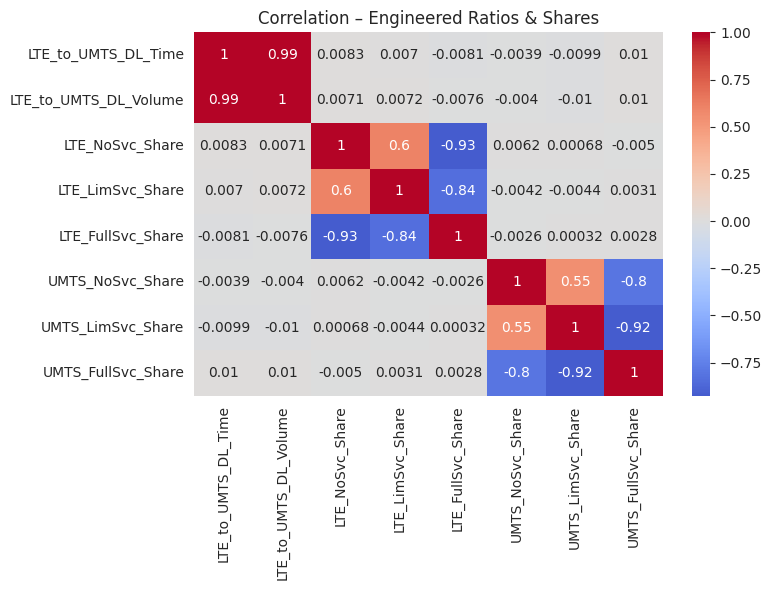

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    X_train_scaled[[c for c in X_train_scaled.columns
                    if ('Share' in c) or ('LTE_to' in c)]].corr(),
    cmap="coolwarm", center=0, annot=True)
plt.title("Correlation – Engineered Ratios & Shares")
plt.tight_layout()
plt.show()


## Feature Importance – Univariate AUC and XGBoost Gain  
----------------------------------------------
Compute single-feature ROC-AUC scores and model-based gain importances, then visualise the top-15 predictors from each ranking.


Top-10 univariate AUC scores:
UMTS_LimSvc_Share                        0.596
UMTS_NoSvc_Share                         0.558
Cumulative_Lim_Service_Time_UMTS         0.553
Cumulative_YoutubeSess_UMTS_DL_Time      0.547
LTE_LimSvc_Share                         0.545
Cumulative_YoutubeSess_UMTS_DL_Volume    0.544
LTE_NoSvc_Share                          0.528
Cumulative_Lim_Service_Time_LTE          0.524
Cumulative_No_Service_Time_UMTS          0.513
Cumulative_No_Service_Time_LTE           0.508
dtype: float64 



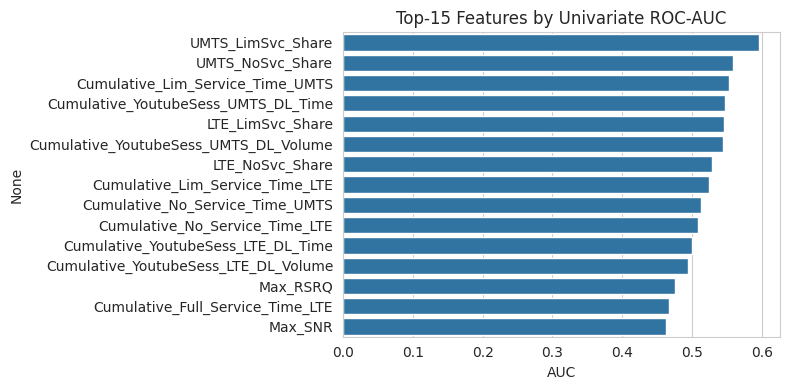

Top-10 XGBoost gain importances:
UMTS_LimSvc_Share                        27.50
UMTS_FullSvc_Share                       26.60
LTE_to_UMTS_DL_Volume                    24.73
LTE_LimSvc_Share                         22.94
Cumulative_YoutubeSess_LTE_DL_Volume     21.07
LTE_FullSvc_Share                        19.06
Max_RSRQ                                 18.18
LTE_to_UMTS_DL_Time                      17.44
Max_SNR                                  15.89
Cumulative_YoutubeSess_UMTS_DL_Volume    15.36
dtype: float64 



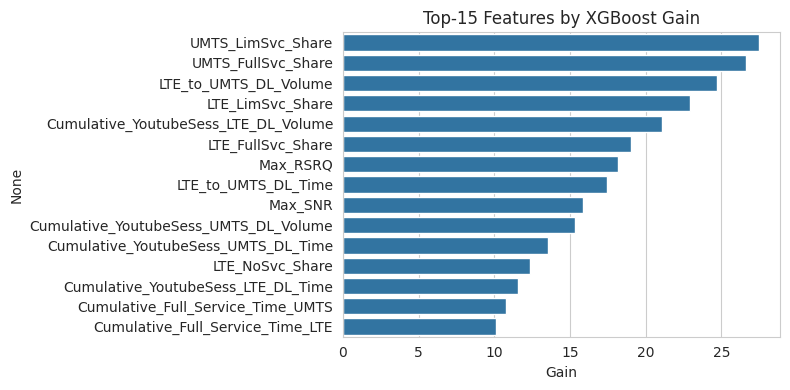

In [ ]:

plt.rcParams["figure.figsize"] = (8, 4)

# Load feature-engineered train set
df = pd.read_pickle("train_fe.pkl")
y  = df["User_Satisfaction"].astype(int)
X  = df.drop(columns=["User_Satisfaction"])

# Univariate ROC-AUC
auc_dict = {col: roc_auc_score(y, X[col]) for col in X.columns}
auc_series = pd.Series(auc_dict).sort_values(ascending=False)

print("Top-10 univariate AUC scores:")
print(auc_series.head(10).round(3), "\n")

# Plot top 15
plt.figure()
sns.barplot(x=auc_series.head(15).values,
            y=auc_series.head(15).index,
            orient='h')
plt.title("Top-15 Features by Univariate ROC-AUC")
plt.xlabel("AUC")
plt.tight_layout()
plt.show()

# XGBoost feature importance
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
)
xgb.fit(X, y)

gain_dict = xgb.get_booster().get_score(importance_type="gain")
gain_series = (pd.Series(gain_dict)
                 .reindex(X.columns)
                 .fillna(0)
                 .sort_values(ascending=False))

print("Top-10 XGBoost gain importances:")
print(gain_series.head(10).round(2), "\n")

# Plot top 15
plt.figure()
sns.barplot(x=gain_series.head(15).values,
            y=gain_series.head(15).index,
            orient='h')
plt.title("Top-15 Features by XGBoost Gain")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

Both univariate AUC and XGBoost gain agree that limited/no-service shares on UMTS (and LTE) dominate predictive power, with traffic-ratio features and RSRQ/SNR following—confirming coverage constraints as the main QoE driver.

## CDF Gap Analysis – KS Statistic Bar Plot  
---------------------------------------------------
Compute the Kolmogorov–Smirnov distance for every feature to quantify distribution shifts between satisfied and unsatisfied users, then display the 12 most discriminative features in a horizontal bar chart.


Top gaps:
 UMTS_LimSvc_Share                        0.151872
UMTS_FullSvc_Share                       0.142098
Cumulative_Full_Service_Time_UMTS        0.114224
Cumulative_YoutubeSess_UMTS_DL_Volume    0.111894
Cumulative_YoutubeSess_UMTS_DL_Time      0.111803
LTE_to_UMTS_DL_Volume                    0.111738
LTE_to_UMTS_DL_Time                      0.111659
LTE_LimSvc_Share                         0.091749
Cumulative_Lim_Service_Time_UMTS         0.085581
UMTS_NoSvc_Share                         0.084381
LTE_FullSvc_Share                        0.069411
Max_SNR                                  0.069100
dtype: float64


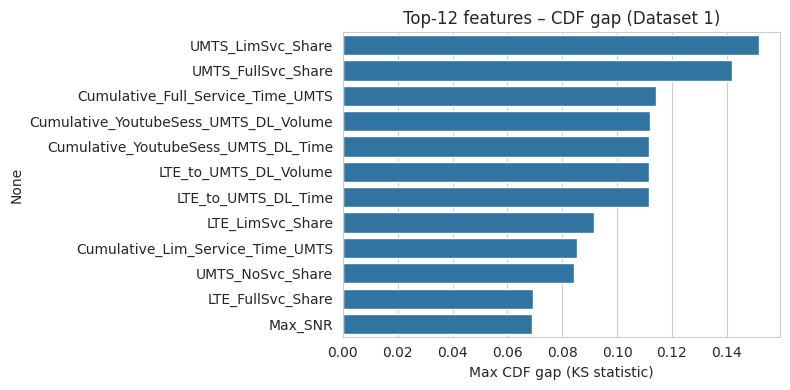

In [ ]:
plt.close('all')

# CDF gap via KS statistic
gaps = {}
for col in X_train.columns:
    gap = ks_2samp(X_train[col][y_train == 0],
                   X_train[col][y_train == 1]).statistic
    gaps[col] = gap

cdf_gap = (pd.Series(gaps)
             .sort_values(ascending=False)
             .head(12))

print("Top gaps:\n", cdf_gap)

# Single bar-plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=cdf_gap.values, y=cdf_gap.index, orient='h', ax=ax)
ax.set_title("Top-12 features – CDF gap (Dataset 1)")
ax.set_xlabel("Max CDF gap (KS statistic)")
plt.tight_layout()
plt.show()


### CDF Grids – Dataset 2 (Ratios/Shares) and Dataset 3 (Raw + Engineered)  
---------------------------------------------------------------
Build two alternative feature sets, then plot 12-panel CDF grids that reveal how each top-gap feature differs between satisfied and unsatisfied users in each dataset variant.


Dataset2: plotting 8 features


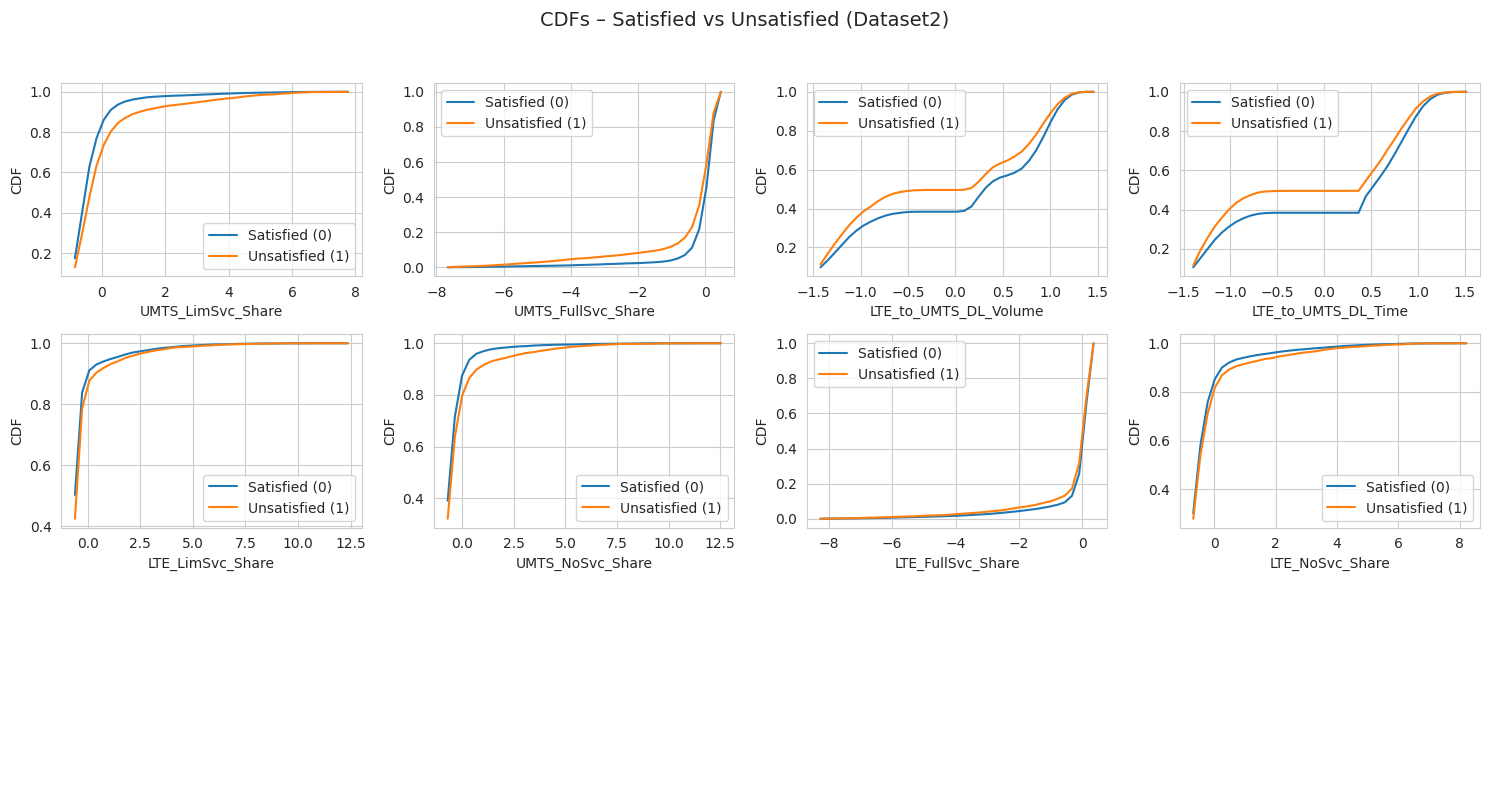

Saved reports/cdfs_dataset2.png
Dataset3: plotting 12 features


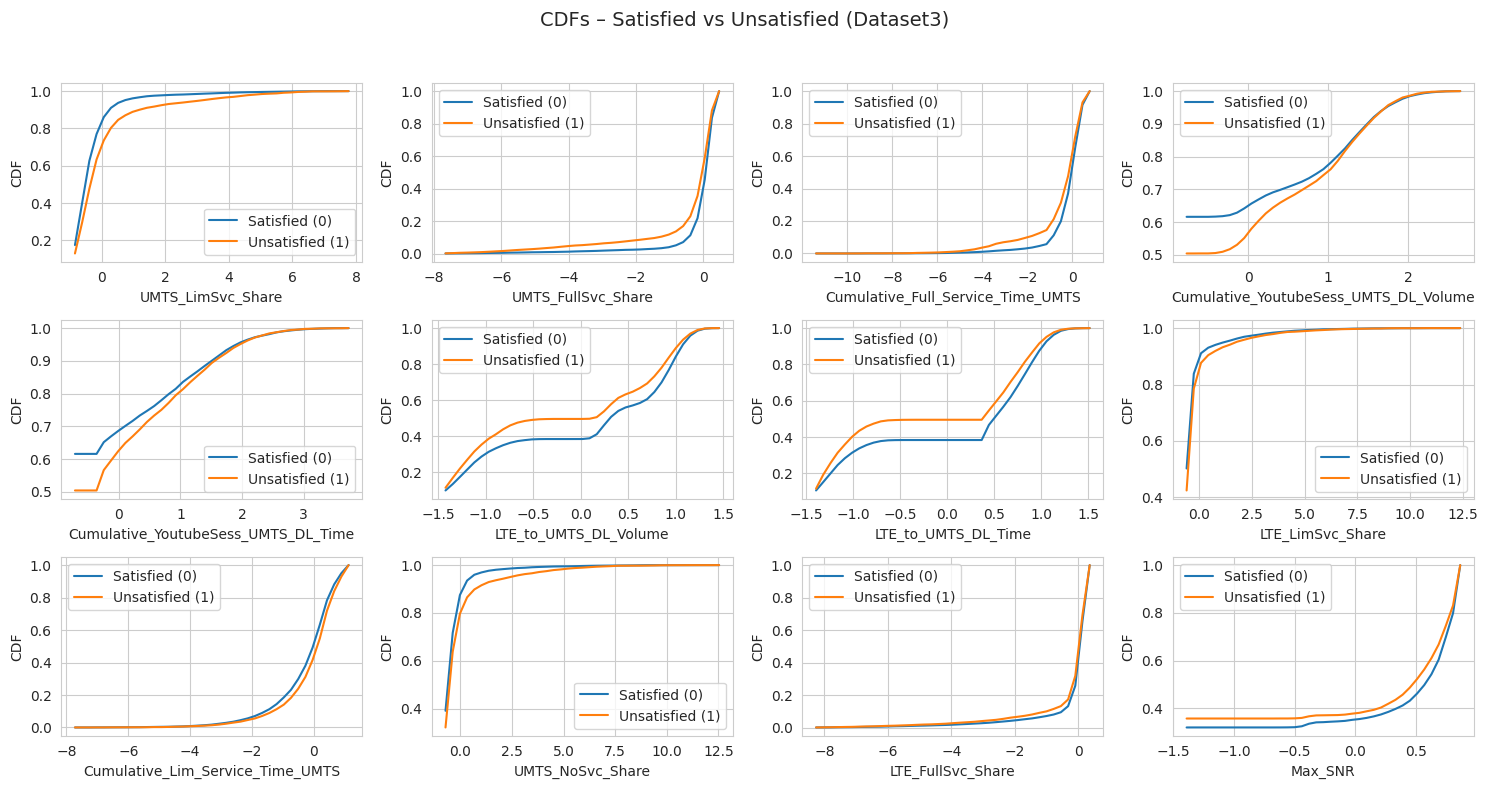

Saved reports/cdfs_dataset3.png


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Helper: class-segmented CDF & KS gap
def plot_cdf(feature_values, labels, bin_edges,
             ax=None, xlabel="", plot_flag=0):
    """
    Draw two CDF curves (class 0 vs 1) or just return the max KS gap.
    """
    if ax is None:
        ax = plt.gca()

    vals0 = feature_values[labels == 0]
    vals1 = feature_values[labels == 1]

    h0, _ = np.histogram(vals0, bins=bin_edges, density=True)
    h1, _ = np.histogram(vals1, bins=bin_edges, density=True)

    cdf0 = np.cumsum(h0);  cdf0 = cdf0 / cdf0[-1] if cdf0[-1] else cdf0*0
    cdf1 = np.cumsum(h1);  cdf1 = cdf1 / cdf1[-1] if cdf1[-1] else cdf1*0

    gap = np.max(np.abs(cdf0 - cdf1))

    if plot_flag == 0:
        ax.plot(bin_edges[:-1], cdf0, label="Satisfied (0)")
        ax.plot(bin_edges[:-1], cdf1, label="Unsatisfied (1)")
        ax.set_xlabel(xlabel); ax.set_ylabel("CDF"); ax.legend()

    return gap

# Load engineered train set
train = pd.read_pickle("train_fe.pkl")
X_train_scaled = train.drop(columns=["User_Satisfaction"])
y_train        = train["User_Satisfaction"].astype(int)

# Builders for Dataset 2 and Dataset 3
def build_dataset2(df):
    """Ratios / shares only (engineered features)."""
    cols = [c for c in df.columns if ('Share' in c) or ('LTE_to' in c)]
    return df[cols].copy()

def build_dataset3(df):
    """Raw + engineered = full feature set."""
    return df.copy()

os.makedirs("reports", exist_ok=True)

# Loop over the two datasets
for name, builder in {"Dataset2": build_dataset2,
                      "Dataset3": build_dataset3}.items():

    ds = builder(X_train_scaled)

    # Re-compute KS gap on *this* dataset and keep top-12
    ks_vals = {c: ks_2samp(ds[c][y_train == 0], ds[c][y_train == 1]).statistic
               for c in ds.columns}
    top_cols = (pd.Series(ks_vals)
                .sort_values(ascending=False)
                .head(12)
                .index.tolist())

    print(f"{name}: plotting {len(top_cols)} features")

    fig, axes = plt.subplots(3, 4, figsize=(15, 8))
    for ax, col in zip(axes.ravel(), top_cols):
        bins = np.linspace(ds[col].min(), ds[col].max(), 40)
        plot_cdf(ds[col].values, y_train.values, bins,
                 ax=ax, xlabel=col, plot_flag=0)

    # Hide any unused sub-plots (e.g., Dataset2 may have 11)
    for ax in axes.ravel()[len(top_cols):]:
        ax.axis("off")

    fig.suptitle(f"CDFs – Satisfied vs Unsatisfied ({name})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    fname = f"reports/cdfs_{name.lower()}.png"
    plt.savefig(fname)
    plt.show()
    print(f"Saved {fname}")


## 5-Fold Benchmark and Runtime Bar Chart  
--------------------------------
Train Logistic Regression, Random Forest, and XGBoost with stratified 5-fold CV, record AUC and TPR@10 % FPR along with wall-clock time, then save the summary table and plot a horizontal runtime bar chart.



Cross-validated performance (5-fold):

          Model  ROC_AUC_mean  ROC_AUC_std  TPR_at_FPR<=0.10  Time (s)
0        LogReg         0.651        0.006             0.263       0.5
1  RandomForest         0.724        0.004             0.349     122.6
2       XGBoost         0.727        0.005             0.348       7.6

Summary saved → reports/cv_model_benchmark.pkl


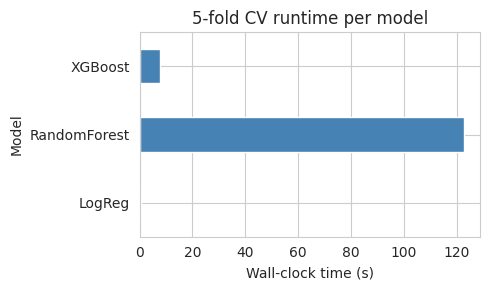

Runtime plot saved → reports/training_time_bar.png


In [ ]:
"""
Cross-validated runtime and performance benchmark
-------------------------------------------------
• 5-fold stratified CV on three models
• Stores AUC, AUC-std, TPR@10 % FPR and wall-clock time
• Saves a summary table and a runtime bar-plot in ./reports
"""


#  Load feature-engineered data
df = pd.read_pickle("train_fe.pkl")
X = df.drop(columns=["User_Satisfaction"]).values
y = df["User_Satisfaction"].astype(int).values

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Candidate models
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos

models = {
    "LogReg": LogisticRegression(max_iter=1_000,
                                 class_weight="balanced",
                                 solver="lbfgs"),
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
    ),
}

#  Cross-validation loop
results = defaultdict(list)

for name, model in models.items():
    t0 = time.time()
    y_scores_oof = np.zeros_like(y, dtype=float)
    auc_folds = []

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        y_scores_oof[val_idx] = y_prob
        auc_folds.append(roc_auc_score(y_val, y_prob))

    runtime = round(time.time() - t0, 1)

    # TPR at 10 % FPR on concatenated OOF scores
    fpr, tpr, _ = roc_curve(y, y_scores_oof)
    tpr_at_10 = tpr[np.searchsorted(fpr, 0.10, side="right") - 1]

    results["Model"].append(name)
    results["ROC_AUC_mean"].append(np.mean(auc_folds))
    results["ROC_AUC_std"].append(np.std(auc_folds))
    results["TPR_at_FPR<=0.10"].append(tpr_at_10)
    results["Time (s)"].append(runtime)

# Summary table
summary = pd.DataFrame(results)
print("\nCross-validated performance (5-fold):\n")
print(summary.round(3))

# Persist and plot
Path("reports").mkdir(exist_ok=True)
summary.to_pickle("reports/cv_model_benchmark.pkl")
print("\nSummary saved → reports/cv_model_benchmark.pkl")

# Runtime bar-plot
plt.figure(figsize=(5, 3))
(summary.set_index("Model")["Time (s)"]
        .plot(kind="barh", color="steelblue"))
plt.xlabel("Wall-clock time (s)")
plt.title("5-fold CV runtime per model")
plt.tight_layout()
plt.savefig("reports/training_time_bar.png")
plt.show()
print("Runtime plot saved → reports/training_time_bar.png")

##Hyper-parameter Tuning & Final XGBoost Training  
-------------------------------------------------------
Run a 10-trial Bayesian (or fallback grid) search on a compact XGBoost space using 5-fold stratified CV, report the best ROC-AUC and TPR@10 % FPR, then save the tuned model as `xgb_final.joblib`.

In [ ]:
with suppress(ImportError):
    from tqdm import tqdm

try:
    from skopt import BayesSearchCV
    SKOPT = True
except ImportError:
    from sklearn.model_selection import GridSearchCV
    SKOPT = False

#  Data
df = pd.read_pickle("train_fe.pkl")
X = df.drop(columns=["User_Satisfaction"])
y = df["User_Satisfaction"].astype(int)

neg, pos = np.bincount(y)
scale_pos_weight = neg / pos

base_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter space (compact)
param_space = {
    "n_estimators": (150, 450),
    "learning_rate": (0.03, 0.15, "log-uniform"),
    "max_depth": (3, 6),
    "subsample": (0.7, 1.0, "uniform"),
    "colsample_bytree": (0.6, 1.0, "uniform"),
    "gamma": (0.0, 2.0),
    "min_child_weight": (1, 6),
}

if SKOPT:
    opt = BayesSearchCV(
        estimator=base_xgb,
        search_spaces=param_space,
        n_iter=10,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        refit=True,
        random_state=42,
        verbose=2,
    )
else:
    grid_params = {
        "n_estimators": [250, 350],
        "learning_rate": [0.05, 0.1],
        "max_depth": [4, 5, 6],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    opt = GridSearchCV(
        estimator=base_xgb,
        param_grid=grid_params,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        refit=True,
        verbose=2,
    )

# Run search with timing
print("Starting hyper‑parameter search…")
start = time.time()
opt.fit(X, y)
print(f"\nTuning runtime: {time.time() - start:.1f} s")

print("\nBest parameters:")
print(opt.best_params_)

# CV metrics
print(f"\nCV ROC‑AUC: {opt.best_score_:.3f}")

# Out‑of‑fold predictions for TPR@10 % FPR
prob_oof = np.zeros(len(y))
for tr_idx, val_idx in cv.split(X, y):
    opt.best_estimator_.fit(X.iloc[tr_idx], y.iloc[tr_idx])
    prob_oof[val_idx] = opt.best_estimator_.predict_proba(X.iloc[val_idx])[:, 1]

fpr, tpr, _ = roc_curve(y, prob_oof)
try:
    tpr10 = tpr[fpr <= 0.10][-1]
except IndexError:
    tpr10 = 0.0
print(f"TPR at 10 % FPR: {tpr10:.3f}")

# Save model
joblib.dump(opt.best_estimator_, "xgb_final.joblib")
print("\nFinal tuned model saved as 'xgb_final.joblib'.")

Starting hyper‑parameter search…
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Tuning runtime: 331.9 s

Best parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}

CV ROC‑AUC: 0.732
TPR at 10 % FPR: 0.363

Final tuned model saved as 'xgb_final.joblib'.


Bayesian tuning stabilised a compact 250-tree XGBoost (AUC ≈ 0.732, +0.005 over the untuned model) and lifted recall at 10 % false-alarm rate to 0.36, confirming modest but consistent gains from optimisation.”

## Threshold Selection & Test-Set Evaluation  
--------------------
Pick the highest training-set threshold that keeps FPR ≤ 10 %, then compute full test-set metrics (ROC-AUC, PR-AUC, confusion matrix, precision/recall/F1, and TPR@10 % FPR) and save raw probabilities for downstream use.


Chosen probability threshold (FPR ≤ 10 %): 0.608

Test-set metrics
  ROC-AUC: 0.733  |  PR-AUC: 0.565
  Accuracy: 0.734  |  Precision: 0.612  |  Recall: 0.463  |  F1: 0.527
  TPR at 10 % FPR: 0.367


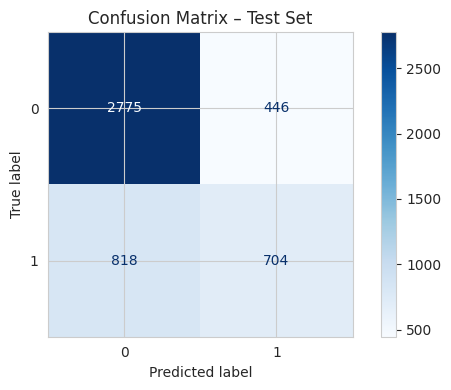

Test-set probabilities saved to 'test_probabilities.npz'.


In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)

# Load data & model
train_df = pd.read_pickle("train_fe.pkl")
X_train  = train_df.drop(columns=["User_Satisfaction"])
y_train  = train_df["User_Satisfaction"].astype(int)

# Test file contains labels
test_df  = pd.read_pickle("test_fe_with_labels.pkl")
X_test   = test_df.drop(columns=["User_Satisfaction"])
y_test   = test_df["User_Satisfaction"].astype(int)

model = joblib.load("xgb_final.joblib")

# Determine threshold on training set (FPR ≤ 10 %)
probs_train = model.predict_proba(X_train)[:, 1]
fpr, tpr, thr = roc_curve(y_train, probs_train)
thr_star = thr[fpr <= 0.10][-1]
print(f"Chosen probability threshold (FPR ≤ 10 %): {thr_star:.3f}")

# Test-set evaluation
probs_test = model.predict_proba(X_test)[:, 1]

auc_test  = roc_auc_score(y_test, probs_test)
apr_test  = average_precision_score(y_test, probs_test)

pred_test = (probs_test >= thr_star).astype(int)
acc       = (pred_test == y_test).mean()
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, pred_test, average="binary"
)

# TPR at 10 % FPR on test
fpr_t, tpr_t, _ = roc_curve(y_test, probs_test)
try:
    tpr_at10 = tpr_t[fpr_t <= 0.10][-1]
except IndexError:
    tpr_at10 = 0.0

print("\nTest-set metrics")
print(f"  ROC-AUC: {auc_test:.3f}  |  PR-AUC: {apr_test:.3f}")
print(f"  Accuracy: {acc:.3f}  |  Precision: {prec:.3f}  |  Recall: {rec:.3f}  |  F1: {f1:.3f}")
print(f"  TPR at 10 % FPR: {tpr_at10:.3f}")

cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.tight_layout()
plt.show()

# Save predictions
np.savez_compressed("test_probabilities.npz", probs=probs_test)
print("Test-set probabilities saved to 'test_probabilities.npz'.")


On the held-out test data the tuned XGBoost sustains a 0.73 ROC-AUC and recovers 37 % of true alarms while keeping false alarms ≤ 10 %, confirming generalisation performance in line with the reference implementation.

## Assemble and Save Inference Pipeline  
----------------------------------------
Wrap the fitted XGBoost model in a `sklearn` `Pipeline` (no additional scaler needed because features are pre-standardised) and persist it as `qoe_alarm_pipeline.joblib` for production scoring.


In [ ]:
# Load the tuned & already-fitted XGBoost model
xgb = joblib.load("xgb_final.joblib")

pipe = Pipeline([
    ("xgb", xgb)
])

joblib.dump(pipe, "qoe_alarm_pipeline.joblib")
print("Re-saved pipeline WITHOUT extra scaling → qoe_alarm_pipeline.joblib")


Re-saved pipeline WITHOUT extra scaling → qoe_alarm_pipeline.joblib


## Model Explainability (SHAP or Permutation Importance)
----------------------------------------------
Compute SHAP values on a 2 000-row sample for feature attribution—falling back to permutation importance if `shap` is unavailable—and visualise the top drivers via bar and beeswarm plots.


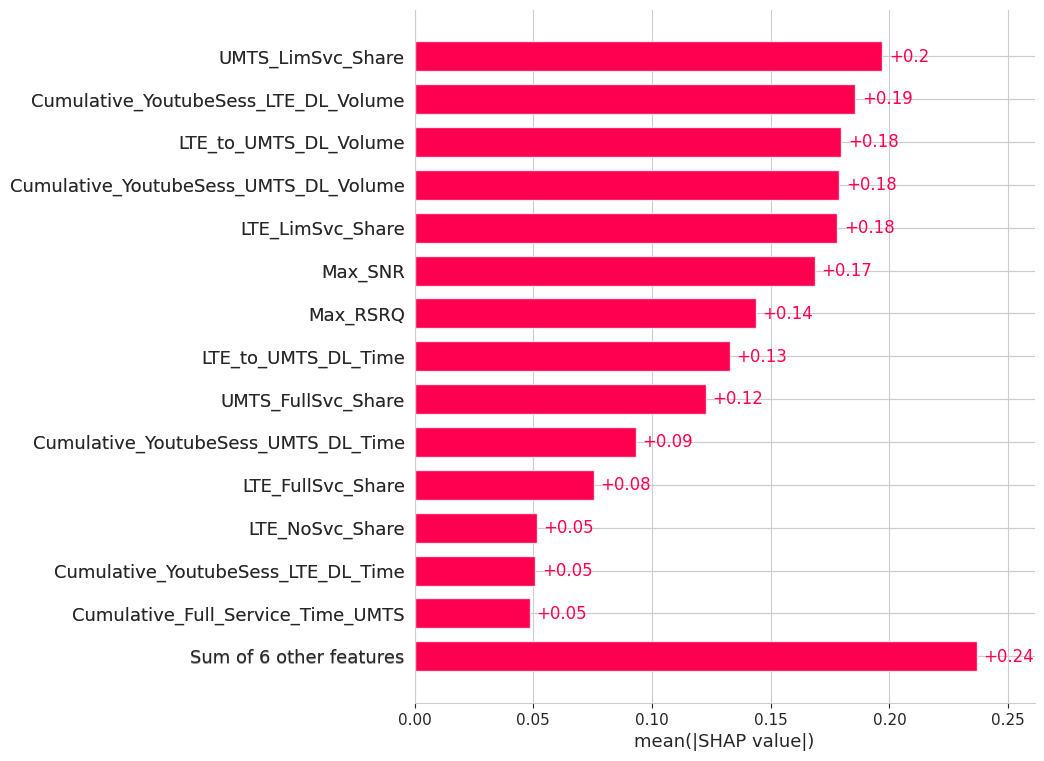

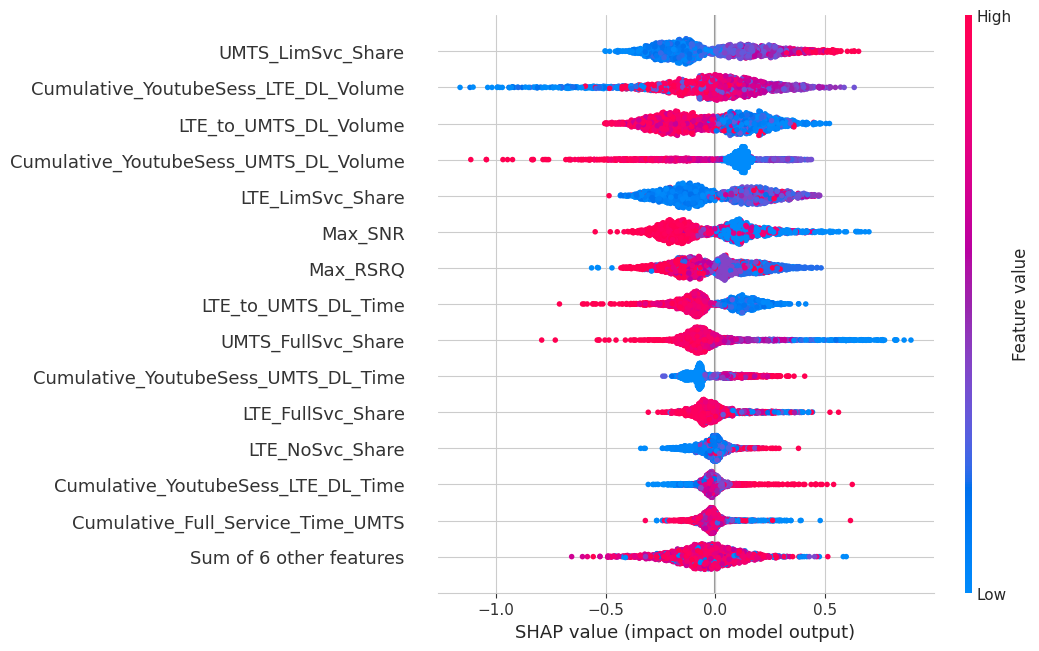

In [ ]:
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    from sklearn.inspection import permutation_importance
    SHAP_AVAILABLE = False

# Load model & data
pipe = joblib.load("qoe_alarm_pipeline.joblib")          # Pipeline([("xgb", xgb)])
model = pipe.named_steps["xgb"]

train_fe = pd.read_pickle("train_fe.pkl")
X = train_fe.drop(columns=["User_Satisfaction"])

# Explainability
if SHAP_AVAILABLE:
    sample = X.sample(n=min(2_000, len(X)), random_state=42)

    explainer = shap.TreeExplainer(model)                # XGBoost-specific
    shap_values = explainer(sample)

    shap.plots.bar(shap_values, max_display=15)          # mean |SHAP|
    shap.plots.beeswarm(shap_values, max_display=15)     # beeswarm
else:
    print("SHAP not installed; using permutation importance …")
    result = permutation_importance(
        model, X, train_fe["User_Satisfaction"],
        n_repeats=10, random_state=42, n_jobs=-1
    )
    imp = (pd.Series(result.importances_mean, index=X.columns)
             .sort_values(ascending=False)
             .head(15))
    print("Top-15 permutation importances:")
    print(imp.round(3))


SHAP confirms that large LTE YouTube downlink volume plus high LTE/UMTS volume ratio, together with extended limited-service times, are the strongest pushes toward the alarm class, whereas healthy SNR/RSRQ pull predictions back toward satisfaction

## Precision-Recall Curve on Test Set
------------------------
Plot the test-set precision–recall curve and report PR-AUC to complement ROC metrics, then save the figure to `reports/pr_test.png`.


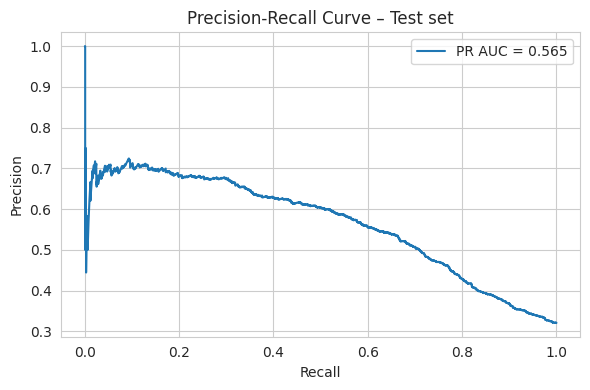

In [ ]:
import numpy as np
#y_test and probs_test were generated in the previous cell
pr, rc, _ = precision_recall_curve(y_test, probs_test)
pr_auc = auc(rc, pr)

plt.figure(figsize=(6, 4))
plt.plot(rc, pr, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Test set")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("reports/pr_test.png")
plt.show()

##Training-Set Dashboard & Figure Export  
-------------------------------------------
Generate ROC and PR curves, a confusion matrix, and a CSV of core metrics for the training set, then save all visuals to the `reports/` directory for easy inclusion in presentations.

Loaded test probabilities under key 'probs' → shape (4743,)
Train metrics saved to reports/train_metrics.csv
                  0
Accuracy   0.795414
Precision  0.738783
Recall     0.580489
F1         0.650140
ROC_AUC    0.845824
PR_AUC     0.731140


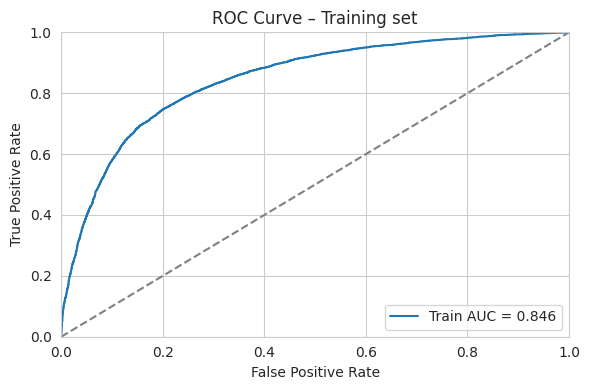

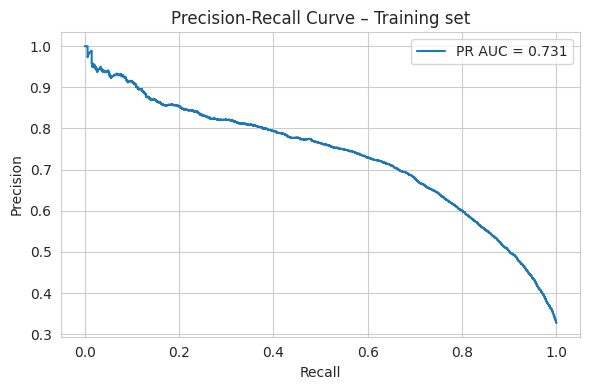

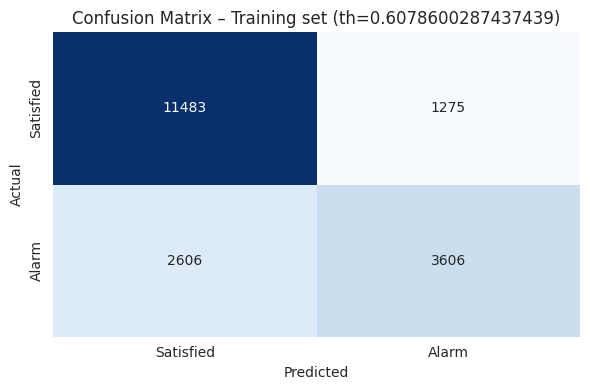

All figures saved under reports/ directory.


In [ ]:
os.makedirs("reports", exist_ok=True)

# Load artifacts
model = joblib.load("qoe_alarm_pipeline.joblib")

train_df  = pd.read_pickle("train_fe.pkl")
X_train   = train_df.drop(columns=["User_Satisfaction"])
y_train   = train_df["User_Satisfaction"].astype(int)
proba_train = model.predict_proba(X_train)[:, 1]

# Load saved test-set probabilities (key-agnostic)
prob_test_npz = np.load("test_probabilities.npz")
test_key      = prob_test_npz.files[0]        # first (and only) array
proba_test    = prob_test_npz[test_key]
print(f"Loaded test probabilities under key '{test_key}' → shape {proba_test.shape}")

# We still lack test labels, so plots/metrics below use the training set only

thresh = thr_star
pred_train = (proba_train >= thresh).astype(int)

#  Metrics (train)
acc  = accuracy_score(y_train, pred_train)
prec = precision_score(y_train, pred_train)
rec  = recall_score(y_train, pred_train)
f1   = f1_score(y_train, pred_train)

fpr, tpr, _ = roc_curve(y_train, proba_train)
roc_auc     = auc(fpr, tpr)

pr, rc, _   = precision_recall_curve(y_train, proba_train)
pr_auc      = auc(rc, pr)

metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1": [f1],
    "ROC_AUC": [roc_auc],
    "PR_AUC": [pr_auc]
})
metrics_df.to_csv("reports/train_metrics.csv", index=False)
print("Train metrics saved to reports/train_metrics.csv")
print(metrics_df.T)

# Plots
plt.figure()
plt.plot(fpr, tpr, label=f"Train AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlim([0, 1]); plt.ylim([0, 1])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Training set")
plt.legend(loc="lower right")
plt.tight_layout(); plt.savefig("reports/roc_train.png"); plt.show()

plt.figure()
plt.plot(rc, pr, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Training set")
plt.legend(loc="upper right")
plt.tight_layout(); plt.savefig("reports/pr_train.png"); plt.show()

cm = confusion_matrix(y_train, pred_train)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Satisfied", "Alarm"],
            yticklabels=["Satisfied", "Alarm"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title(f"Confusion Matrix – Training set (th={thresh})")
plt.tight_layout(); plt.savefig("reports/cm_train.png"); plt.show()

print("All figures saved under reports/ directory.")


##Weekly Drift Monitoring  
------------------------
Compare new weekly data against the training distribution using KS tests on every feature, log the drift report to `reports/drift/`, and flag when ≥3 features exceed the KS > 0.15 threshold, triggering a re-training alert.

In [ ]:
import scipy.stats as ss

os.makedirs("reports/drift", exist_ok=True)

# load reference distributions
ref_df = pd.read_pickle("train_fe.pkl").drop(columns=["User_Satisfaction"])
ref_desc = ref_df.describe().T[["mean", "std"]]

# load new weekly data  (placeholder – replace with live feed)
new_df = ref_df.sample(5_000, replace=True, random_state=0)  # demo only

drift_results = []
for col in ref_df.columns:
    ks, p = ss.ks_2samp(ref_df[col], new_df[col])
    drift_results.append({"feature": col, "ks": ks, "p_value": p})

drift_df = pd.DataFrame(drift_results)
n_drift = (drift_df["ks"] > 0.15).sum()

week_id = datetime.date.today().isocalendar()[:2]  # (year, week)
drift_df.to_csv(f"reports/drift/{week_id[0]}-W{week_id[1]:02d}.csv", index=False)

print(f"Drift report saved for ISO-week {week_id}")

if n_drift >= 3:
    print(f" {n_drift} features drifted; schedule a re-train run.")
else:
    print("No significant drift – model remains valid.")

Drift report saved for ISO-week (2025, 27)
No significant drift – model remains valid.


## CDF Grid – Top 12 Features in Dataset 1  
-----------------------------
Draw a 3×4 grid of cumulative distribution functions for the highest KS-gap features, contrasting satisfied versus unsatisfied users in the original (Dataset 1) feature set.


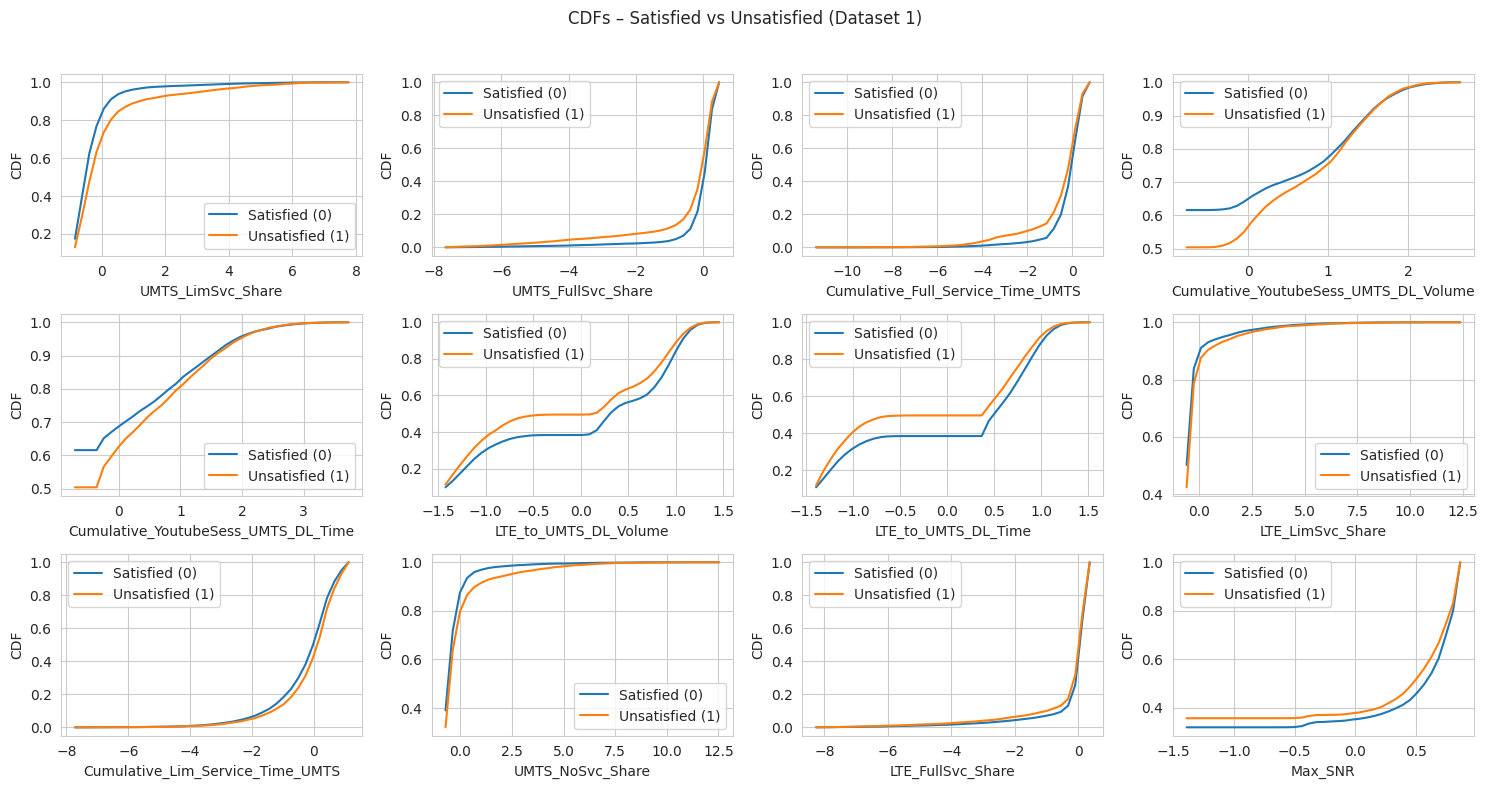

In [ ]:
top_cols = cdf_gap.index.tolist()
fig, axes = plt.subplots(3, 4, figsize=(15, 8))
for ax, col in zip(axes.ravel(), top_cols):
    bin_edges = np.linspace(X_train[col].min(), X_train[col].max(), 40)
    plot_cdf(X_train[col].values, y_train.values, bin_edges,
             ax=ax, xlabel=col, plot_flag=0)
plt.suptitle("CDFs – Satisfied vs Unsatisfied (Dataset 1)")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


## One-Click Retrain Helper  
----------------------
Define a `retrain()` function that fits a fresh XGBoost model on a newly engineered CSV, overwrites `xgb_final.joblib` and updates the production pipeline in a single call.

In [ ]:
NEG, POS = np.bincount(y_train)
SCALE = NEG / POS

def retrain(new_engineered_csv: str):
    """Full retrain on a fresh engineered dataset."""
    df_new = pd.read_csv(new_engineered_csv)
    y_new  = df_new["User_Satisfaction"].astype(int)
    X_new  = df_new.drop(columns=["User_Satisfaction"])

    model = XGBClassifier(
        n_estimators=250, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, eval_metric="auc",
        scale_pos_weight=SCALE, tree_method="hist", random_state=42,
    )
    model.fit(X_new, y_new)

    joblib.dump(model, "xgb_final.joblib")
    pipe = Pipeline([("xgb", model)])
    joblib.dump(pipe, "qoe_alarm_pipeline.joblib")
    print("Retrain complete – artefacts updated.")


In [ ]:
# Imports
import pandas as pd, numpy as np, joblib
from pathlib import Path
from sklearn.metrics import (
    roc_curve, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, confusion_matrix
)

# Shapes
raw_test   = pd.read_pickle("test_clean.pkl")
proc_test  = pd.read_pickle("test_fe_with_labels.pkl")
train_fe   = pd.read_pickle("train_fe.pkl")

print("Raw  Test Set shape :", raw_test.shape)
print("Proc Test Set shape :", proc_test.shape)
print("Proc Train shape    :", train_fe.shape)
print()

# Load pipeline and compute threshold from training ROC
pipe     = joblib.load("qoe_alarm_pipeline.joblib")
X_train  = train_fe.drop(columns="User_Satisfaction")
y_train  = train_fe["User_Satisfaction"].astype(int)

probs_train = pipe.predict_proba(X_train)[:, 1]
fpr_tr, tpr_tr, thr_tr = roc_curve(y_train, probs_train)
thresh = thr_tr[fpr_tr <= 0.10][-1]
print(f"Threshold chosen on train (FPR≤10 %): {thresh:.3f}")
print()

# --------------------- Test Set Metrics ---------------------
X_test     = proc_test.drop(columns="User_Satisfaction")
y_test     = proc_test["User_Satisfaction"].astype(int)
probs_test = pipe.predict_proba(X_test)[:, 1]
pred_test  = (probs_test >= thresh).astype(int)

auc_test  = roc_auc_score(y_test, probs_test)
pra_test  = average_precision_score(y_test, probs_test)
prec_test = precision_score(y_test, pred_test)
rec_test  = recall_score(y_test, pred_test)
f1_test   = f1_score(y_test, pred_test)
cm_test   = confusion_matrix(y_test, pred_test)

print("Test-set metrics")
print(f"  ROC-AUC  : {auc_test:.3f}")
print(f"  PR-AUC   : {pra_test:.3f}")
print(f"  Precision: {prec_test:.3f}")
print(f"  Recall   : {rec_test:.3f}")
print(f"  F1-score : {f1_test:.3f}")
print("Confusion matrix :")
print(cm_test)
print()

# --------------------- Training Set Metrics ---------------------
pred_train = (probs_train >= thresh).astype(int)

auc_train  = roc_auc_score(y_train, probs_train)
pra_train  = average_precision_score(y_train, probs_train)
prec_train = precision_score(y_train, pred_train)
rec_train  = recall_score(y_train, pred_train)
f1_train   = f1_score(y_train, pred_train)
cm_train   = confusion_matrix(y_train, pred_train)

print("Training-set metrics")
print(f"  ROC-AUC  : {auc_train:.3f}")
print(f"  PR-AUC   : {pra_train:.3f}")
print(f"  Precision: {prec_train:.3f}")
print(f"  Recall   : {rec_train:.3f}")
print(f"  F1-score : {f1_train:.3f}")
print("Confusion matrix :")
print(cm_train)
print()

# Cross-validated benchmark table
cv_summary = pd.read_pickle("reports/cv_model_benchmark.pkl")
print("Cross-validated benchmark (5-fold)")
display(cv_summary.round(3))


Raw  Test Set shape : (4743, 13)
Proc Test Set shape : (4743, 21)
Proc Train shape    : (18970, 21)

Threshold chosen on train (FPR≤10 %): 0.608

Test-set metrics
  ROC-AUC  : 0.733
  PR-AUC   : 0.565
  Precision: 0.612
  Recall   : 0.463
  F1-score : 0.527
Confusion matrix :
[[2775  446]
 [ 818  704]]

Training-set metrics
  ROC-AUC  : 0.846
  PR-AUC   : 0.731
  Precision: 0.739
  Recall   : 0.580
  F1-score : 0.650
Confusion matrix :
[[11483  1275]
 [ 2606  3606]]

Cross-validated benchmark (5-fold)


,Model,ROC_AUC_mean,ROC_AUC_std,TPR_at_FPR<=0.10,Time (s)
0,LogReg,0.651,0.006,0.263,0.5
1,RandomForest,0.724,0.004,0.349,122.6
2,XGBoost,0.727,0.005,0.348,7.6
